# 10.9 Lab Deep Learning

In [1]:
! pip install ISLP

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 3.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1

In [2]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

In [4]:
from torchmetrics import MeanAbsoluteError, R2Score
from torchsummary import summary
from torchvision.io import read_image

In [5]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

In [6]:
torch.manual_seed(0)
np.random.seed(0)
torch.use_deterministic_algorithms(True, warn_only=True)

In [7]:
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import Resize, Normalize, CenterCrop, ToTensor

In [8]:
from ISLP.torch import SimpleDataModule, SimpleModule, ErrorTracker, rec_num_workers

In [9]:
from ISLP.torch.imdb import load_lookup, load_tensor, load_sparse, load_sequential

In [10]:
from glob import glob
import json

## 10.9.1 Single Layer Network on Hitters Data


In [11]:
Hitters = load_data('Hitters').dropna()
n = Hitters.shape[0]
n

263

In [12]:
model = MS(Hitters.columns.drop('Salary'), intercept  = False)
X = model.fit_transform(Hitters).to_numpy()
y = Hitters['Salary'].to_numpy()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 1/3, random_state = 1)

### Linear Models

In [14]:
hit_lm = LinearRegression().fit(X_train, y_train)
pred = hit_lm.predict(X_test)
test = np.abs(pred - y_test).mean()
test

259.7152883314631

In [15]:
scaler = StandardScaler(with_mean = True, with_std = True)
lasso = Lasso(warm_start = True, max_iter = 30000)
standard_lasso = Pipeline(steps = [('scaler', scaler), ('lasso', lasso)])

In [16]:
X_s = scaler.fit_transform(X_train)
n = X_s.shape[0]
lam_max = np.fabs(X_s.T.dot(y_train - y_train.mean())).max() / n
param_grid = {'alpha': np.exp(np.linspace(0, np.log(0.01), 100)) * lam_max}

In [17]:
cv = KFold(10, shuffle = True, random_state = 1)
grid = GridSearchCV(lasso, param_grid, cv = cv, scoring = 'neg_mean_absolute_error').fit(X_train, y_train);


In [18]:
best_lasso = grid.best_estimator_
best_predict = best_lasso.predict(X_test)
mae = np.abs(best_predict - y_test).mean()
mae

257.23820107995

### Specifying a Network: Classes and Inheritance

In [19]:
class HittersModel(nn.Module):

  def __init__(self, input_size):
    super(HittersModel, self).__init__()
    self.flatten = nn.Flatten()
    self.sequential = nn.Sequential(
        nn.Linear(input_size,50),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(50,1)
    )

  def forward(self,x):
    x = self.flatten(x)
    return torch.flatten(self.sequential(x))

In [20]:
hit_model = HittersModel(X.shape[1])

In [21]:

summary(hit_model, input_size=(1, X_train.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                   [-1, 19]               0
            Linear-2                   [-1, 50]           1,000
              ReLU-3                   [-1, 50]               0
           Dropout-4                   [-1, 50]               0
            Linear-5                    [-1, 1]              51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [22]:
! pip install torchinfo
from torchinfo import summary

In [23]:
summary(hit_model, input_size=X_train.shape, col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

In [24]:
X_train_t = torch.tensor(X_train.astype(np.float32))
y_train_t = torch.tensor(y_train.astype(np.float32))
hit_train = TensorDataset(X_train_t, y_train_t)

In [25]:
X_test_t = torch.tensor(X_test.astype(np.float32))
y_test_t = torch.tensor(y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t, y_test_t)

In [26]:
max_num_workers = rec_num_workers()

In [27]:
hit_dm = SimpleDataModule(hit_train, hit_test, batch_size = 32, num_workers = min(4, max_num_workers), validation = hit_test)

In [28]:
hit_module = SimpleModule.regression(hit_model, metrics = {'mae':MeanAbsoluteError()})

In [30]:
hit_logger = CSVLogger('logs', name = "hitters")

In [33]:
hit_trainer = Trainer(deterministic = True, max_epochs = 50, log_every_n_steps =5, logger = hit_logger, callbacks = [ErrorTracker()])
hit_trainer.fit(hit_module, datamodule = hit_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | HittersModel | 1.1 K  | train
1 | loss  | MSELoss      | 0      | train
-----------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [34]:
hit_trainer.test(hit_module, datamodule = hit_dm)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │      115111.3671875       │
│         test_mae          │    212.48394775390625     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 115111.3671875, 'test_mae': 212.48394775390625}]

In [35]:
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)

In [36]:
def summary_plot(results, ax, col='loss', valid_legend='Validation', training_legend='Training', ylabel='Loss',fontsize=20):
  for( column, color, label) in zip([f'train_{col}_epoch', f'valid_{col}'], ['black','red'], [training_legend, valid_legend]):
    results.plot(x='epoch', y=column, label=label, marker='o',color=color, ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

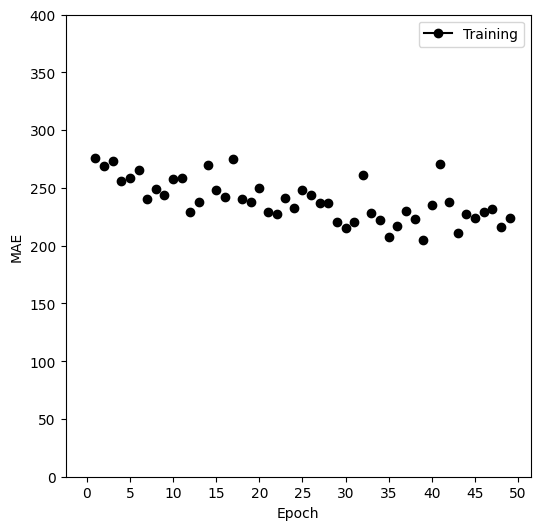

In [37]:
fig, ax = subplots(1, 1, figsize=(6, 6))
ax = summary_plot(hit_results, ax, col='mae', ylabel='MAE', valid_legend='Validation (=Test)')
ax.set_ylim([0, 400])
ax.set_xticks(np.linspace(0, 50, 11).astype(int));

In [39]:
hit_model.eval()
preds= hit_model(X_test_t)
torch.abs(y_test_t - preds).mean()

tensor(212.4839, grad_fn=<MeanBackward0>)

In [40]:
del(Hitters, hit_model, hit_dm, hit_logger, hit_test, hit_train,X, y, X_test, X_train, y_test, y_train, X_test_t, y_test_t, hit_trainer, hit_module)

## 10.9.2 Multilayer Network on the MNIST Digit Data

In [43]:
(mnist_train, mnist_test) = [MNIST(root = 'data', train = train, download = True, transform = ToTensor()) for train in [True, False]]
mnist_train

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 21033708.12it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 609822.21it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 5605981.05it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2788018.26it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [56]:
mnist_dm = SimpleDataModule(mnist_train, mnist_test, validation = 0.2, num_workers = max_num_workers, batch_size = 256)

In [57]:
for idx,(X_, Y_) in enumerate(mnist_dm.train_dataloader()):
  print('X :', X_.shape)
  print('Y :', Y_.shape)
  if idx >= 1: break


X : torch.Size([256, 1, 28, 28])
Y : torch.Size([256])
X : torch.Size([256, 1, 28, 28])
Y : torch.Size([256])


In [58]:
class MNISTModel(nn.Module):
  def __init__(self):
    super(MNISTModel, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 256),
        nn.ReLU(),
        nn.Dropout(0.4)
    )
    self.layer2 = nn.Sequential(
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.4)
    )
    self._forward = nn.Sequential(
        self.layer1,
        self.layer2,
        nn.Linear(128,10)
    )
  def forward(self, x):
    return self._forward(x)

In [59]:
mnist_model = MNISTModel()

In [60]:
mnist_model(X_).size()

torch.Size([256, 10])

In [61]:
summary(mnist_model, input_data = X_, col_names = ['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTModel                               [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Sequential: 2-1                   [256, 1, 28, 28]          [256, 256]                --
│    │    └─Flatten: 3-1                 [256, 1, 28, 28]          [256, 784]                --
│    │    └─Linear: 3-2                  [256, 784]                [256, 256]                200,960
│    │    └─ReLU: 3-3                    [256, 256]                [256, 256]                --
│    │    └─Dropout: 3-4                 [256, 256]                [256, 256]                --
│    └─Sequential: 2-2                   [256, 256]                [256, 128]                --
│    │    └─Linear: 3-5                  [256, 256]                [256, 128]                32,896
│    │    └─ReLU: 3-6     

In [64]:
mnist_module = SimpleModule.classification(mnist_model, num_classes = 10)
mnist_logger = CSVLogger('logs', name='MNIST')

In [66]:
mnist_trainer = Trainer(deterministic = True, max_epochs = 30, logger = mnist_logger, callbacks = [ErrorTracker()])
mnist_trainer.fit(mnist_module, datamodule = mnist_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | MNISTModel       | 235 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.941     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


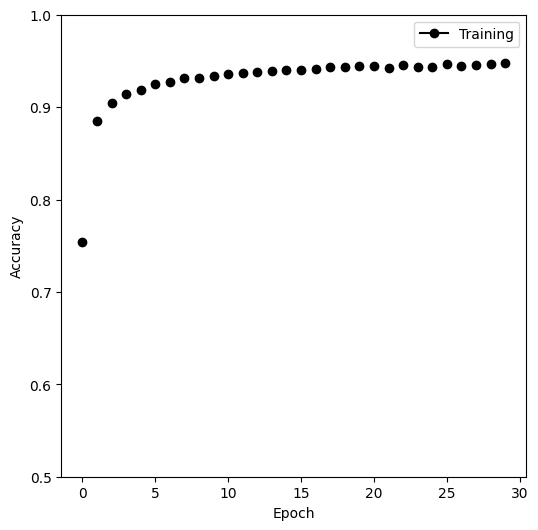

In [68]:
mnist_results = pd.read_csv(mnist_logger.experiment.metrics_file_path)
fig, ax = subplots(1,1, figsize = (6,6))
summary_plot(mnist_results, ax, col = 'accuracy', ylabel = 'Accuracy')
ax.set_ylim([0.5,1])
ax.set_ylabel('Accuracy')
ax.set_xticks(np.linspace(0,30,7).astype(int))

In [69]:
mnist_trainer.test(mnist_module, datamodule = mnist_dm)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9664000272750854     │
│         test_loss         │    0.1552717238664627     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.1552717238664627, 'test_accuracy': 0.9664000272750854}]

In [70]:
class MNIST_MLR(nn.Module):
  def __init__(self):
    super(MNIST_MLR,self).__init__()
    self.linear = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 10)
    )

  def forward(self, x):
    return self.linear(x)

In [71]:
mlr_model = MNIST_MLR()
mlr_module = SimpleModule.classification(mlr_model, num_classes = 10)
mlr_logger = CSVLogger('logs', name = 'MNIST_MLR')

In [72]:
mlr_trainer = Trainer(deterministic = True, max_epochs = 30, callbacks = [ErrorTracker()])
mlr_trainer.fit(mlr_module, datamodule = mnist_dm)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | MNIST_MLR        | 7.9 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [73]:
mlr_trainer.test(mlr_module, datamodule = mnist_dm)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9226999878883362     │
│         test_loss         │    0.32689642906188965    │
└───────────────────────────┴───────────────────────────┘

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[{'test_loss': 0.32689642906188965, 'test_accuracy': 0.9226999878883362}]

In [74]:
del(mnist_train, mnist_test, mnist_model, mnist_dm, mnist_trainer, mnist_module, mnist_results, mlr_model, mlr_module, mlr_trainer)

### 10.9.3 Convolutional Neural Networks

In [75]:
(cifar_train, cifar_test) = [CIFAR100(root = 'data', train = train, download = True) for train in [True, False]]


100%|██████████| 169001437/169001437 [00:02<00:00, 61861430.09it/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [76]:
transform = ToTensor()
cifar_train_X = torch.stack([transform(x) for x in cifar_train.data])
cifar_test_X = torch.stack([transform(x) for x in cifar_test.data])

cifar_train = TensorDataset(cifar_train_X, torch.tensor(cifar_train.targets))
cifar_test = TensorDataset(cifar_test_X, torch.tensor(cifar_test.targets))

In [77]:
cifar_dm = SimpleDataModule(cifar_train, cifar_test, batch_size = 128, validation = 0.2, num_workers = max_num_workers)


In [78]:
for idx, (X_,Y_) in enumerate(cifar_dm.train_dataloader()):
  print('X :', X_.shape)
  print('Y :', Y_.shape)
  if idx >= 1: break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


X : torch.Size([128, 3, 32, 32])
Y : torch.Size([128])
X : torch.Size([128, 3, 32, 32])
Y : torch.Size([128])


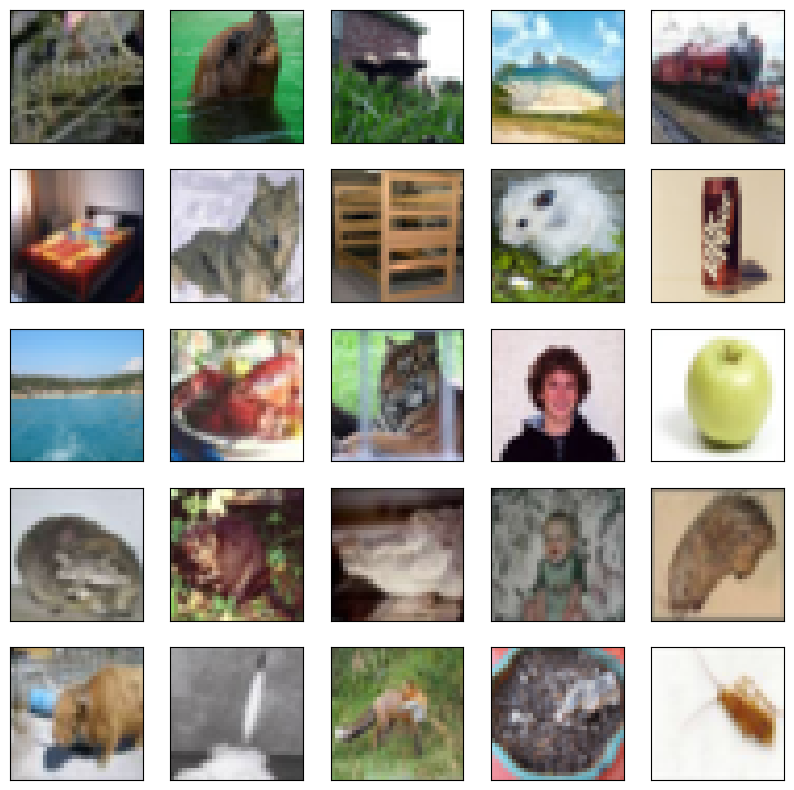

In [79]:
fig, axes = subplots(5, 5, figsize=(10,10))
rng = np.random.default_rng(4)
indices = rng.choice(np.arange(len(cifar_train)), 25, replace=False).reshape((5,5))
for i in range(5):
  for j in range(5):
    idx = indices[i,j]
    axes[i,j].imshow(np.transpose(cifar_train[idx][0],[1,2,0]), interpolation=None)
    axes[i,j].set_xticks([])
    axes[i,j].set_yticks([])

In [80]:
class BuildingBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(BuildingBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = (3,3), padding = 'same')
    self.activation = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size = (2,2))
  def forward(self, x):
    return self.pool(self.activation(self.conv(x)))


In [85]:
class CIFARModel(nn.Module):

  def __init__(self):
    super(CIFARModel, self).__init__()
    sizes = [(3,32),(32,64),(64,128),(128,256)]
    self.conv = nn.Sequential(*[BuildingBlock(in_, out_) for in_ , out_ in sizes])
    self.output = nn.Sequential(nn.Dropout(0.5),nn.Linear(2*2*256, 512), nn.ReLU(), nn.Linear(512,100))

  def forward(self, x):
    val = self.conv(x)
    val = torch.flatten(val, start_dim = 1)
    return self.output(val)

In [86]:
cifar_model = CIFARModel()
summary(cifar_model, input_data=X_, col_names=['input_size', 'output_size','num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CIFARModel                               [128, 3, 32, 32]          [128, 100]                --
├─Sequential: 1-1                        [128, 3, 32, 32]          [128, 256, 2, 2]          --
│    └─BuildingBlock: 2-1                [128, 3, 32, 32]          [128, 32, 16, 16]         --
│    │    └─Conv2d: 3-1                  [128, 3, 32, 32]          [128, 32, 32, 32]         896
│    │    └─ReLU: 3-2                    [128, 32, 32, 32]         [128, 32, 32, 32]         --
│    │    └─MaxPool2d: 3-3               [128, 32, 32, 32]         [128, 32, 16, 16]         --
│    └─BuildingBlock: 2-2                [128, 32, 16, 16]         [128, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [128, 32, 16, 16]         [128, 64, 16, 16]         18,496
│    │    └─ReLU: 3-5                    [128, 64, 16, 16]         [128, 64, 16, 16]         --
│    │    └─MaxPool2d: 3-6    

In [87]:
cifar_optimizer = RMSprop(cifar_model.parameters(), lr=0.001)
cifar_module = SimpleModule.classification(cifar_model, optimizer = cifar_optimizer, num_classes = 100)
cifar_logger = CSVLogger('logs', name = 'CIFAR')

In [91]:
cifar_trainer = Trainer(deterministic = True, max_epochs = 5, logger = cifar_logger, callbacks = [ErrorTracker()])
cifar_trainer.fit(cifar_module, datamodule = cifar_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory logs/CIFAR/version_0/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | CIFARModel       | 964 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
964 K     Trainable params
0         Non-trainable params
964 K     Total params
3.858     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


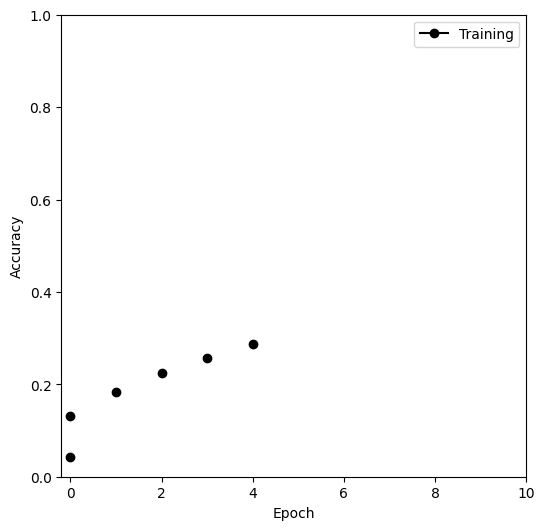

In [93]:
log_path = cifar_logger.experiment.metrics_file_path
cifar_results = pd.read_csv(log_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(cifar_results, ax, col='accuracy', ylabel='Accuracy')
ax.set_xticks(np.linspace(0, 10, 6).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1]);

In [94]:
cifar_trainer.test(cifar_module, datamodule = cifar_dm)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.3000999987125397     │
│         test_loss         │    2.7812678813934326     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.7812678813934326, 'test_accuracy': 0.3000999987125397}]

### Hardware Acceleration

In [92]:
try:
  for name, metric in cifar_module.metrics.items():
    cifar_module.metrics[name] = metric.to('mps')
  cifar_trainer_mps = Trainer(accelerator='mps', deterministic=True, max_epochs=30)
  cifar_trainer_mps.fit(cifar_module, datamodule=cifar_dm)
  cifar_trainer_mps.test(cifar_module, datamodule=cifar_dm)
except:
  pass

## 10.9.4 Using Pretrained CNN Models

In [95]:
resize = Resize((232,232))
crop = CenterCrop(224)
normalize = Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
imgfiles = sorted([f for f in glob('book_images/*')])
imgs = torch.stack([torch.div(crop(resize(read_image(f))), 255) for f in imgfiles])
imgs = normalize(imgs)
imgs.size()

torch.Size([6, 3, 224, 224])

In [96]:
resnet_model = resnet50(weights = ResNet50_Weights.DEFAULT)
summary(resnet_model, input_data = imgs, col_names = ['input_size', 'output_size', 'num_params'])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth

  0%|          | 0.00/97.8M [00:00<?, ?B/s]
  1%|          | 1.12M/97.8M [00:00<00:08, 11.7MB/s]
 10%|▉         | 9.62M/97.8M [00:00<00:01, 56.6MB/s]
 17%|█▋        | 16.5M/97.8M [00:00<00:01, 63.6MB/s]
 25%|██▍       | 24.1M/97.8M [00:00<00:01, 69.8MB/s]
 33%|███▎      | 32.1M/97.8M [00:00<00:00, 74.8MB/s]
 42%|████▏     | 41.2M/97.8M [00:00<00:00, 81.8MB/s]
 50%|█████     | 49.2M/97.8M [00:00<00:00, 82.5MB/s]
 60%|█████▉    | 58.5M/97.8M [00:00<00:00, 86.9MB/s]
 69%|██████▉   | 67.6M/97.8M [00:00<00:00, 89.6MB/s]
 78%|███████▊  | 76.2M/97.8M [00:01<00:00, 89.7MB/s]
 87%|████████▋ | 84.9M/97.8M [00:01<00:00, 88.4MB/s]
100%|██████████| 97.8M/97.8M [00:01<00:00, 72.7MB/s]


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [6, 3, 224, 224]          [6, 1000]                 --
├─Conv2d: 1-1                            [6, 3, 224, 224]          [6, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [6, 64, 112, 112]         [6, 64, 112, 112]         128
├─ReLU: 1-3                              [6, 64, 112, 112]         [6, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [6, 64, 112, 112]         [6, 64, 56, 56]           --
├─Sequential: 1-5                        [6, 64, 56, 56]           [6, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [6, 64, 56, 56]           [6, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [6, 64, 56, 56]           [6, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [6, 64, 56, 56]           [6, 64, 56, 56]           128
│    │    └─ReLU: 3-3      

In [97]:
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [98]:
imgs_pred = resnet_model(imgs)


In [101]:
img_probs = np.exp(np.asarray(imgs_pred.detach()))
img_probs /= img_probs.sum(1)[:,None]

In [104]:
labs = json.load(open('imagenet_class_index.json'))
class_labels = pd.DataFrame([(int(k), v[1]) for k, v in labs.items()], columns=['idx', 'label'])
class_labels = class_labels.set_index('idx')
class_labels = class_labels.sort_index()

In [105]:
for i, imgfile in enumerate(imgfiles):
  img_df = class_labels.copy()
  img_df['prob'] = img_probs[i]
  img_df = img_df.sort_values(by='prob', ascending=False)[:3]
  print(f'Image: {imgfile}')
  print(img_df.reset_index().drop(columns=['idx']))

Image: book_images/Cape_Weaver.jpg
      label      prob
0   jacamar  0.297499
1     macaw  0.068107
2  lorikeet  0.051104
Image: book_images/Flamingo.jpg
            label      prob
0        flamingo  0.609514
1       spoonbill  0.013586
2  American_egret  0.002132
Image: book_images/Hawk_Fountain.jpg
            label      prob
0            kite  0.184681
1           robin  0.084022
2  great_grey_owl  0.061274
Image: book_images/Hawk_cropped.jpg
            label      prob
0            kite  0.453834
1  great_grey_owl  0.015914
2             jay  0.012210
Image: book_images/Lhasa_Apso.jpg
             label      prob
0            Lhasa  0.260317
1         Shih-Tzu  0.097195
2  Tibetan_terrier  0.032819
Image: book_images/Sleeping_Cat.jpg
         label      prob
0  Persian_cat  0.163070
1        tabby  0.074143
2    tiger_cat  0.042578


In [106]:
del(cifar_test, cifar_train, cifar_dm, cifar_module, cifar_logger, cifar_optimizer, cifar_trainer)

## 10.9.5 IMDB Document Classification

In [107]:
(imdb_seq_train, imdb_seq_test) = load_sequential(root='data/IMDB')
padded_sample = np.asarray(imdb_seq_train.tensors[0][0])
sample_review = padded_sample[padded_sample > 0][:12]
sample_review[:12]

Retrieving "IMDB_S_train.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_S_test.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_Y_test.npy" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_Y_train.npy" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468], dtype=int32)

In [108]:
lookup = load_lookup(root='data/IMDB')
' '.join(lookup[i] for i in sample_review)

Retrieving "IMDB_word_index.pkl" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


"<START> this film was just brilliant casting location scenery story direction everyone's"

In [109]:
max_num_workers = 10
(imdb_train, imdb_test) = load_tensor(root = 'data/IMDB')
imdb_dm = SimpleDataModule(imdb_train, imdb_test, batch_size = 512, validation = 2000, num_workers = min(6,max_num_workers))


Retrieving "IMDB_X_test.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_X_train.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


In [111]:
class IMDBModel(nn.Module):
  def __init__(self, input_size):
    super(IMDBModel, self).__init__()
    self.dense1 = nn.Linear(input_size, 16)
    self.activation = nn.ReLU()
    self.dense2 = nn.Linear(16,16)
    self.output = nn.Linear(16,1)
  def forward(self, x):
    val = x
    for _map in [ self.dense1, self.activation, self.dense2, self.activation, self.output]:
      val = _map(val)
    return torch.flatten(val)

In [113]:
imdb_model = IMDBModel(imdb_test.tensors[0].size()[1])
summary(imdb_model, input_size=imdb_test.tensors[0].size(), col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
IMDBModel                                [25000, 10003]            [25000]                   --
├─Linear: 1-1                            [25000, 10003]            [25000, 16]               160,064
├─ReLU: 1-2                              [25000, 16]               [25000, 16]               --
├─Linear: 1-3                            [25000, 16]               [25000, 16]               272
├─ReLU: 1-4                              [25000, 16]               [25000, 16]               --
├─Linear: 1-5                            [25000, 16]               [25000, 1]                17
Total params: 160,353
Trainable params: 160,353
Non-trainable params: 0
Total mult-adds (G): 4.01
Input size (MB): 1000.30
Forward/backward pass size (MB): 6.60
Params size (MB): 0.64
Estimated Total Size (MB): 1007.54

In [114]:
imdb_optimizer = RMSprop(imdb_model.parameters(), lr=0.001)
imdb_module = SimpleModule.binary_classification(imdb_model, optimizer = imdb_optimizer)

In [115]:
idbm_logger = CSVLogger('logs', name = 'IMDB')
imdb_trainer = Trainer(deterministic = True, max_epochs = 30, logger = idbm_logger, callbacks = [ErrorTracker()])
imdb_trainer.fit(imdb_module, datamodule = imdb_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | IMDBModel         | 160 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.641     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [116]:
test_results =imdb_trainer.test(imdb_module, datamodule = imdb_dm)
test_results

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8492400050163269     │
│         test_loss         │    1.1980255842208862     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.1980255842208862, 'test_accuracy': 0.8492400050163269}]

### Comparison to Lasso

In [118]:
((X_train, Y_train),(X_valid, Y_valid), (X_test, Y_test)) = load_sparse(validation=2000, random_state=0, root='data/IMDB')

In [119]:
lam_max = np.abs(X_train.T * (Y_train - Y_train.mean())).max()
lam_val = lam_max * np.exp(np.linspace(np.log(1), np.log(1e-4), 50))

In [120]:
logit = LogisticRegression(penalty='l1', C=1/lam_max, solver='liblinear', warm_start=True, fit_intercept=True)

In [121]:
coefs = []
intercepts = []
for l in lam_val:
  logit.C = 1/l
  logit.fit(X_train, Y_train)
  coefs.append(logit.coef_.copy())
  intercepts.append(logit.intercept_)

In [122]:
coefs = np.squeeze(coefs)
intercepts = np.squeeze(intercepts)

In [123]:
%%capture
fig, axes = subplots(1, 2, figsize=(16, 8), sharey=True)
for ((X_, Y_), data_, color) in zip([(X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test)], ['Training', 'Validation', 'Test'], ['black', 'red', 'blue']):
  linpred_ = X_ * coefs.T + intercepts[None,:]
  label_ = np.array(linpred_ > 0)
  accuracy_ = np.array([np.mean(Y_ == l) for l in label_.T])
  axes[0].plot(-np.log(lam_val / X_train.shape[0]), accuracy_, '.--', color=color, markersize=13, linewidth=2, label=data_)
axes[0].legend()
axes[0].set_xlabel(r'$-\log(\lambda)$', fontsize=20)
axes[0].set_ylabel('Accuracy', fontsize=20)

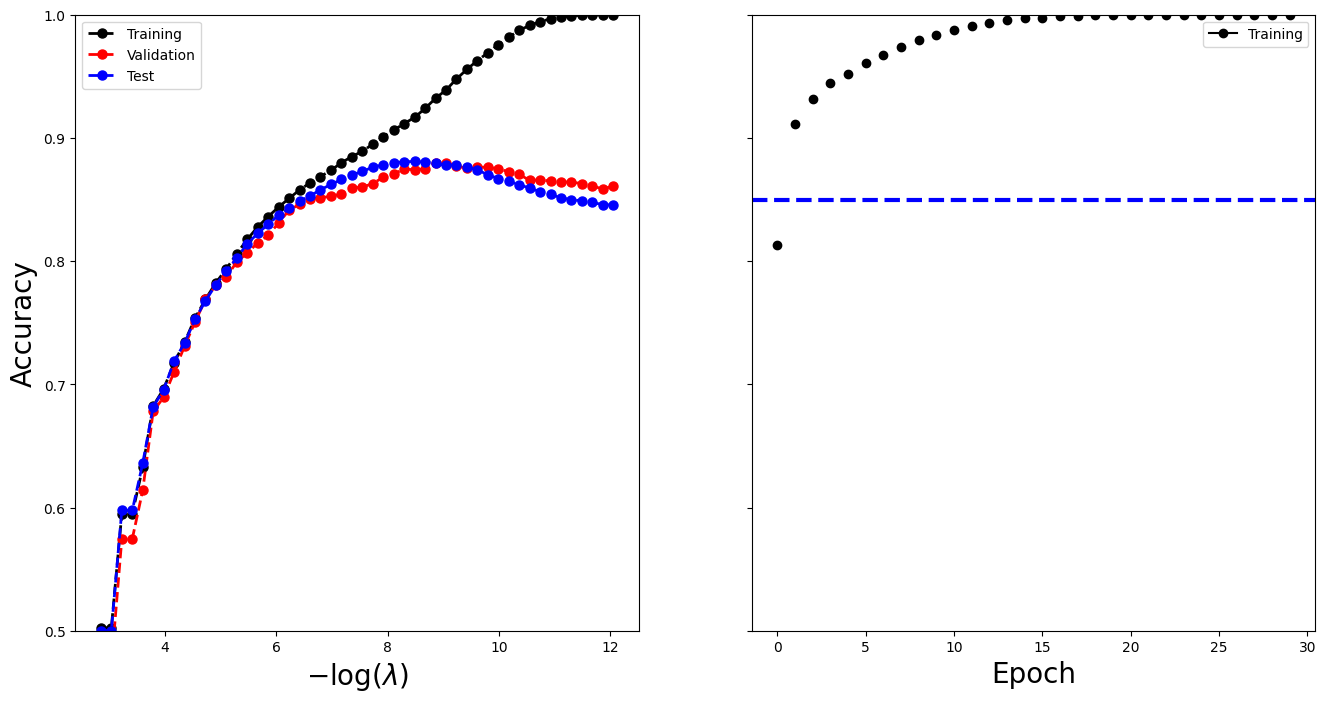

In [125]:
imdb_results = pd.read_csv(idbm_logger.experiment.metrics_file_path)
summary_plot(imdb_results, axes[1], col='accuracy', ylabel='Accuracy')
axes[1].set_xticks(np.linspace(0, 30, 7).astype(int))
axes[1].set_ylabel('Accuracy', fontsize=20)
axes[1].set_xlabel('Epoch', fontsize=20)
axes[1].set_ylim([0.5, 1]);
axes[1].axhline(test_results[0]['test_accuracy'], color='blue', linestyle='--', linewidth=3)
fig

In [132]:
del(idbm_logger, imdb_dm, imdb_train, imdb_test)

## 10.9.6 Recurrent Neural Networks

### Sequential Models for Document Classification

In [133]:
imdb_seq_dm = SimpleDataModule(imdb_seq_train, imdb_seq_test, batch_size = 300, validation = 2000, num_workers = min(6, max_num_workers))

In [134]:
class LSTMModel(nn.Module):
  def __init__(self, input_size):
    super(LSTMModel, self).__init__()
    self.embedding = nn.Embedding(input_size, 32)
    self.lstm = nn.LSTM(input_size = 32, hidden_size =32, batch_first = True)
    self.dense = nn.Linear(32, 1)
  def forward(self, x):
    val, (h_n, c_n) = self.lstm(self.embedding(x))
    return torch.flatten(self.dense(val[:,-1]))


In [136]:
lstm_model = LSTMModel(X_test.shape[-1])
summary(lstm_model, input_data = imdb_seq_train.tensors[0][:10], col_names=['input_size', 'output_size', 'num_params'])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMModel                                [10, 500]                 [10]                      --
├─Embedding: 1-1                         [10, 500]                 [10, 500, 32]             320,096
├─LSTM: 1-2                              [10, 500, 32]             [10, 500, 32]             8,448
├─Linear: 1-3                            [10, 32]                  [10, 1]                   33
Total params: 328,577
Trainable params: 328,577
Non-trainable params: 0
Total mult-adds (M): 45.44
Input size (MB): 50.00
Forward/backward pass size (MB): 2.56
Params size (MB): 1.31
Estimated Total Size (MB): 53.87

In [138]:
lstm_module = SimpleModule.binary_classification(lstm_model)
lstm_logger = CSVLogger('logs', name = 'IMDB_LSTM')

In [143]:
lstm_trainer = Trainer(deterministic = True, max_epochs = 5, logger = lstm_logger, callbacks = [ErrorTracker()])
lstm_trainer.fit(lstm_module, datamodule = imdb_seq_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type              | Params | Mode
---------------------------------------------------
0 | model | LSTMModel         | 328 K  | eval
1 | loss  | BCEWithLogitsLoss | 0      | eval
---------------------------------------------------
328 K     Trainable params
0         Non-trainable params
328 K     Total params
1.314     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [144]:
lstm_trainer.test(lstm_module, datamodule = imdb_seq_dm)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8362799882888794     │
│         test_loss         │    0.4578405022621155     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4578405022621155, 'test_accuracy': 0.8362799882888794}]

(0.5, 1.0)

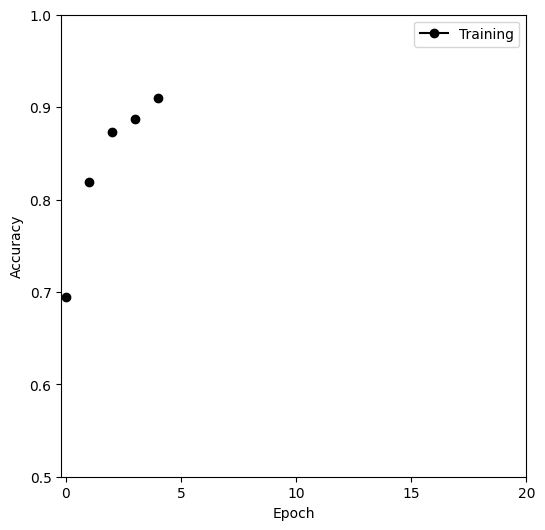

In [146]:
lstm_results = pd.read_csv(lstm_logger.experiment.metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(lstm_results, ax, col='accuracy', ylabel='Accuracy')
ax.set_xticks(np.linspace(0, 20, 5).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1])

### Time Series Prediction

In [149]:
NYSE = load_data('NYSE')
cols = ['DJ_return', 'log_volume', 'log_volatility']
X = pd.DataFrame(StandardScaler(with_mean=True,with_std=True).fit_transform(NYSE[cols]),columns=NYSE[cols].columns,index=NYSE.index)

In [150]:
for lag in range(1, 6):
  for col in cols:
    newcol = np.zeros(X.shape[0]) * np.nan
    newcol[lag:] = X[col].values[:-lag]
    X.insert(len(X.columns), "{0}_{1}".format(col, lag), newcol)
X.insert(len(X.columns), 'train', NYSE['train'])
X = X.dropna()

In [151]:
Y, train = X['log_volume'], X['train']
X = X.drop(columns=['train'] + cols)
X.columns

Index(['DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return_2',
       'log_volume_2', 'log_volatility_2', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_4', 'log_volume_4', 'log_volatility_4',
       'DJ_return_5', 'log_volume_5', 'log_volatility_5'],
      dtype='object')

In [153]:
M = LinearRegression()
M.fit(X[train], Y[train])
M.score(X[~train], Y[~train])

0.4128912938562521

In [154]:
X_day = pd.merge(X, pd.get_dummies(NYSE['day_of_week']),on='date')

In [155]:
M.fit(X_day[train], Y[train])
M.score(X_day[~train], Y[~train])

0.4595563133053274

In [156]:
ordered_cols = []
for lag in range(5,0,-1):
  for col in cols:
    ordered_cols.append('{0}_{1}'.format(col, lag))
X = X.reindex(columns=ordered_cols)
X.columns

Index(['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'DJ_return_4',
       'log_volume_4', 'log_volatility_4', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_2', 'log_volume_2', 'log_volatility_2',
       'DJ_return_1', 'log_volume_1', 'log_volatility_1'],
      dtype='object')

In [157]:
X_rnn = X.to_numpy().reshape((-1,5,3))
X_rnn.shape

(6046, 5, 3)

In [159]:
class NYSEModel(nn.Module):
  def __init__(self):
    super(NYSEModel, self).__init__()
    self.rnn = nn.RNN(3,12, batch_first=True)
    self.dense = nn.Linear(12, 1)
    self.dropout = nn.Dropout(0.1)

  def forward(self, x):
    val, h_n = self.rnn(x)
    val = self.dense(self.dropout(val[:,-1]))
    return torch.flatten(val)
nyse_model = NYSEModel()

In [160]:
datasets = []
for mask in [train, ~train]:
  X_rnn_t = torch.tensor(X_rnn[mask].astype(np.float32))
  Y_t = torch.tensor(Y[mask].astype(np.float32))
  datasets.append(TensorDataset(X_rnn_t, Y_t))
nyse_train, nyse_test = datasets

<ipython-input-160-522e97166f14>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_t = torch.tensor(Y[mask].astype(np.float32))
<ipython-input-160-522e97166f14>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_t = torch.tensor(Y[mask].astype(np.float32))


In [161]:
summary(nyse_model, input_data=X_rnn_t, col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NYSEModel                                [1770, 5, 3]              [1770]                    --
├─RNN: 1-1                               [1770, 5, 3]              [1770, 5, 12]             204
├─Dropout: 1-2                           [1770, 12]                [1770, 12]                --
├─Linear: 1-3                            [1770, 12]                [1770, 1]                 13
Total params: 217
Trainable params: 217
Non-trainable params: 0
Total mult-adds (M): 1.83
Input size (MB): 0.11
Forward/backward pass size (MB): 0.86
Params size (MB): 0.00
Estimated Total Size (MB): 0.97

In [162]:
nyse_dm = SimpleDataModule(nyse_train, nyse_test,
num_workers=min(4, max_num_workers), validation=nyse_test, batch_size=64)

In [163]:
for idx, (x, y) in enumerate(nyse_dm.train_dataloader()):
  out = nyse_model(x)
  print(y.size(), out.size())
  if idx >= 2:break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])


In [164]:
nyse_optimizer = RMSprop(nyse_model.parameters(), lr=0.001)
nyse_module = SimpleModule.regression(nyse_model, optimizer=nyse_optimizer, metrics={'r2':R2Score()})

In [165]:
nyse_trainer = Trainer(deterministic=True, max_epochs=200, callbacks=[ErrorTracker()])
nyse_trainer.fit(nyse_module, datamodule=nyse_dm)
nyse_trainer.test(nyse_module, datamodule=nyse_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | NYSEModel | 217    | train
1 | loss  | MSELoss   | 0      | train
--------------------------------------------
217       Trainable params
0         Non-trainable params
217       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6199111342430115     │
│          test_r2          │    0.4116740822792053     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6199111342430115, 'test_r2': 0.4116740822792053}]

In [168]:
datasets = []
for mask in [train, ~train]:
  X_day_t = torch.tensor( np.asarray(X_day[mask]).astype(np.float32))
  Y_t = torch.tensor(np.asarray(Y[mask]).astype(np.float32))
  datasets.append(TensorDataset(X_day_t, Y_t))
day_train, day_test = datasets

In [169]:
day_dm = SimpleDataModule(day_train, day_test, num_workers=min(4, max_num_workers), validation=day_test, batch_size=64)

In [170]:
class NonLinearARModel(nn.Module):
  def __init__(self):
    super(NonLinearARModel , self).__init__()
    self._forward = nn.Sequential(nn.Flatten(), nn.Linear(20, 32), nn.ReLU(), nn.Dropout(0.5), nn.Linear(32, 1))
  def forward(self, x):
    return torch.flatten(self._forward(x))

In [171]:
nl_model = NonLinearARModel()
nl_optimizer = RMSprop(nl_model.parameters(), lr=0.001)
nl_module = SimpleModule.regression(nl_model, optimizer=nl_optimizer, metrics={'r2':R2Score()})

In [173]:
nl_trainer = Trainer(deterministic=True, max_epochs=30, callbacks=[ErrorTracker()])
nl_trainer.fit(nl_module, datamodule=day_dm)
nl_trainer.test(nl_module, datamodule=day_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | NonLinearARModel | 705    | train
1 | loss  | MSELoss          | 0      | train
---------------------------------------------------
705       Trainable params
0         Non-trainable params
705       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5652012825012207     │
│          test_r2          │    0.4635964035987854     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5652012825012207, 'test_r2': 0.4635964035987854}]